# PMR3508(2020) - Aprendizado de Máquina e Reconhecimento de Padrões

Análise e aplicação de um classificador K-NN na base adult;

Autor: Gabriel Ranieri Vaz de Lima

# 1. Preparação dos Dados (*Data Prep*)

* **Importação de Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


* **Importação de Dados**

In [2]:
adult_train = pd.read_csv("../input/adult-pmr3508/train_data.csv",
        names=[
        "Id","Age", "Workclass", "fnlwgt", "Education", "education-num", "Martial Status",
        "Occupation", "relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        skiprows=1,
        engine='python',
        na_values="?")

adult_test =  pd.read_csv("../input/adult-pmr3508/test_data.csv",
        names=[
        "Id","Age", "Workclass", "fnlwgt", "Education", "education-num", "Martial Status",
        "Occupation", "relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country"],
        sep=r'\s*,\s*',
        skiprows=1,
        engine='python',
        na_values="?")


In [3]:
adult_train.head()

,Id,Age,Workclass,fnlwgt,Education,education-num,Martial Status,Occupation,relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


* **Identificação de dados faltantes (Missing Data)**

A seguir, analisam-se os dados faltantes para se decidir como proceder em relação aos mesmos.

In [4]:
print('Formato do DataFrame: ', adult_train.shape)

Formato do DataFrame:  (32560, 16)


Acima, a descrição da estrutura do Dataframe.

In [5]:
adult_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              32560 non-null  int64 
 1   Age             32560 non-null  int64 
 2   Workclass       30724 non-null  object
 3   fnlwgt          32560 non-null  int64 
 4   Education       32560 non-null  object
 5   education-num   32560 non-null  int64 
 6   Martial Status  32560 non-null  object
 7   Occupation      30717 non-null  object
 8   relationship    32560 non-null  object
 9   Race            32560 non-null  object
 10  Sex             32560 non-null  object
 11  Capital Gain    32560 non-null  int64 
 12  Capital Loss    32560 non-null  int64 
 13  Hours per week  32560 non-null  int64 
 14  Country         31977 non-null  object
 15  Target          32560 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


A partir das informações, indentificam-se dados faltantes apenas em Workclass (1.836), Occupation (1.843) e Country (583). Como as linhas com dados faltantes representam 7,37% da totalidade, decidiu-se desconsiderá-las, pois não impactariam radicalmente na acurácia do classificador.

In [6]:
Nadult_train = adult_train.dropna()
Nadult_test = adult_test.dropna()

Faz-se o mesmo com os dados de teste.

# 2.  **Análise dos Dados**

Nesta etapa, haverá a exploração dos dados para uma melhor compreensão de como se comportam. Já se sabe que os dados possuem 14 atributos, cada um representado por uma coluna, os quais podem ser pouco relevantes ou representar características similiares. Como busca-se classificar a variável que representa a renda anual (Target), é importante entender como os atibutos a influenciam.

* Atributos similares:

Observaremos se existem atributos correlacionados, ou seja, que representam características parecidas.

In [7]:
Nadult_train.apply(preprocessing.LabelEncoder().fit_transform).corr()

,Id,Age,Workclass,fnlwgt,Education,education-num,Martial Status,Occupation,relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
Id,1.000000,-0.008950,0.003467,0.006157,-0.000378,-0.003674,-0.009649,0.004924,-0.002004,0.003632,-0.007869,0.001655,-0.006221,0.000518,0.003274,-0.002498
Age,-0.008950,1.000000,0.080633,-0.078139,-0.001099,0.043543,-0.276618,-0.005656,-0.246619,0.023428,0.082036,0.127099,0.066325,0.102539,-0.001892,0.242196
Workclass,0.003467,0.080633,1.000000,-0.035731,0.017892,0.037729,-0.034338,0.015719,-0.067401,0.044700,0.074917,0.022714,0.011633,0.049054,0.007644,0.018103
fnlwgt,0.006157,-0.078139,-0.035731,1.000000,-0.025358,-0.043898,0.034130,0.001949,0.006867,-0.012018,0.024612,-0.005071,-0.009571,-0.024575,-0.070081,-0.009987
Education,-0.000378,-0.001099,0.017892,-0.025358,1.000000,0.345431,-0.040654,-0.038231,-0.012720,0.011158,-0.027880,0.032229,0.014866,0.060629,0.078794,0.078981
education-num,-0.003674,0.043543,0.037729,-0.043898,0.345431,1.000000,-0.063457,0.087778,-0.091928,0.032791,0.006131,0.154438,0.083868,0.154690,0.091547,0.335317
Martial Status,-0.009649,-0.276618,-0.034338,0.034130,-0.040654,-0.063457,1.000000,0.022702,0.177975,-0.068641,-0.119837,-0.072170,-0.035856,-0.191256,-0.025911,-0.193504
Occupation,0.004924,-0.005656,0.015719,0.001949,-0.038231,0.087778,0.022702,1.000000,-0.053742,0.000736,0.062350,0.018123,0.013878,0.017495,-0.003470,0.051551
relationship,-0.002004,-0.246619,-0.067401,0.006867,-0.012720,-0.091928,0.177975,-0.053742,1.000000,-0.117140,-0.584876,-0.092799,-0.066306,-0.260494,-0.010806,-0.251009
Race,0.003632,0.023428,0.044700,-0.012018,0.011158,0.032791,-0.068641,0.000736,-0.117140,1.000000,0.089178,0.025719,0.023372,0.049021,0.124511,0.071666


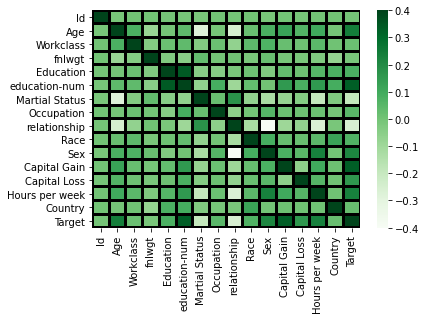

In [8]:
Nadult_train_corr = Nadult_train.apply(preprocessing.LabelEncoder().fit_transform).corr()
sns.heatmap(Nadult_train_corr, vmin=-0.4, vmax=0.4, center=0, cmap='Greens', linewidths=2, linecolor='black')

Primeiramente, observa-se que os pares de atributos: Education e education num, Martial status e relationship representam características similares, dado que a correlação entre eles é muito alta. Por essa razão, Education e relationship serão desconsiderados para a classificação.

Por outro lado, é possível identificar que os atributos fnlwgt, Martial Status, relationship, Workclass e Country estão pouco relacionados com o que busca-se classificar: Target.

Além disso, há uma considerável correlação entre Hours per week e Sex.

* **Age:**

Text(0.5, 0, 'Age')

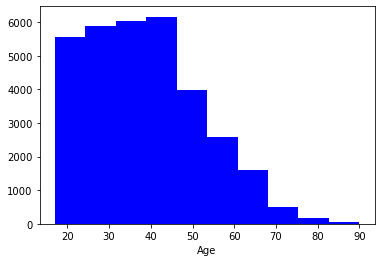

In [9]:
adult_train['Age'].hist(color = 'blue', grid=False, label = True)
plt.xlabel('Age')

A partir do histograma acima, conclui-se que a população estudada possui majoritariamente de 20 a 45 anos.

* **Workclass:**

In [10]:
adult_train['Workclass'].describe()

count       30724
unique          8
top       Private
freq        22696
Name: Workclass, dtype: object

In [11]:
adult_train['Workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1297
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: Workclass, dtype: int64

Com essas informações, inteira-se do fato de que 69,7% da população em questão trabalha na esfera privada. Por conta dessa concentração e pela observação de que o aributo está pouco correlacionado a Target, Workclass não será considerado para a classificação.

* **fnlwgt**

In [12]:
adult_train['fnlwgt'].value_counts()

164190    13
123011    13
203488    13
113364    12
126675    12
          ..
277588     1
277886     1
370045     1
114324     1
229376     1
Name: fnlwgt, Length: 21647, dtype: int64

In [13]:
adult_train['fnlwgt'].describe()

count    3.256000e+04
mean     1.897818e+05
std      1.055498e+05
min      1.228500e+04
25%      1.178315e+05
50%      1.783630e+05
75%      2.370545e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

A partir destes dados, verifica-se que o atributo fnlwgt é muito específico e pouco influencia na renda anual. Por isso,também será desconsiderado.

* **education-num**

Text(0.5, 0, 'Nível Educacional')

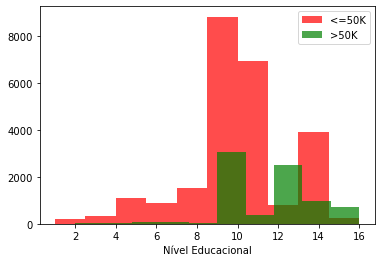

In [14]:
menor50K = adult_train[adult_train['Target'] == '<=50K']
maior50K = adult_train[adult_train['Target'] == '>50K']

menor50K['education-num'].hist(color = 'red', alpha = 0.7, grid = False, label = '<=50K')
maior50K['education-num'].hist(color = 'green', alpha = 0.7, grid = False, label = '>50K')

plt.legend()
plt.xlabel('Nível Educacional')

O histograma acima relaciona o nível educacional (education-num) com a renda anual (Target), é visível que aqueles com maior escolaridade possuem, em sua maioria, maior renda.

* **Occupation:**

In [15]:
adult_train['Occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3769
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: Occupation, dtype: int64

Text(0.5, 1.0, 'Histograma das ocupações de pessoas com renda anual inferior à 50 mil dólares')

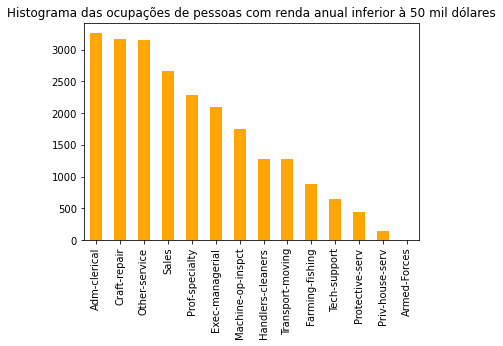

In [16]:
menor50K['Occupation'].value_counts().plot(kind = 'bar', color = 'orange')
plt.title('Histograma das ocupações de pessoas com renda anual inferior à 50 mil dólares')

Text(0.5, 1.0, 'Histograma das ocupações de pessoas com renda anual superior à 50 mil dólares')

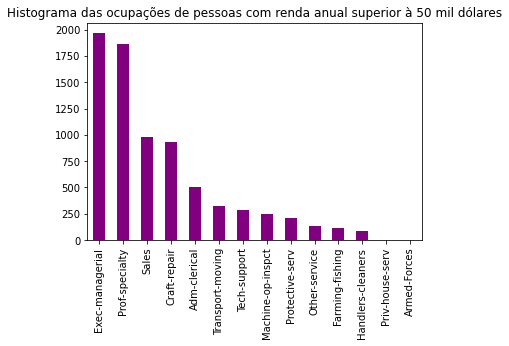

In [17]:
maior50K['Occupation'].value_counts().plot(kind = 'bar', color = 'purple')
plt.title('Histograma das ocupações de pessoas com renda anual superior à 50 mil dólares')

Observa-se que as ocupações mais comuns entre pessoas com renda anual superior à 50 mil dólares são Exec-managerial e Prof-specially, enquanto as das com renda anual inferior a essa quantia são Adm-clerical e Craft-repair.

* **Race:**

In [18]:
adult_train['Race'].value_counts()

White                 27815
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: Race, dtype: int64

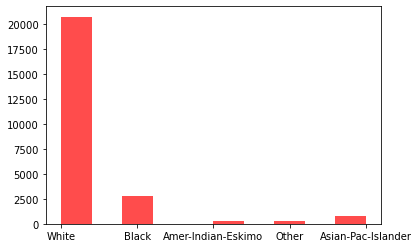

In [19]:
menor50K['Race'].hist(color = 'red', alpha = 0.7, grid = False, label = '<=50K')


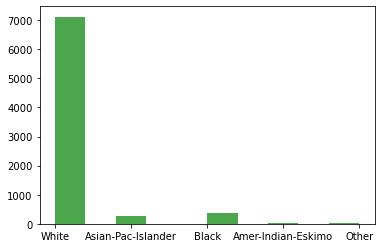

In [20]:
maior50K['Race'].hist(color = 'green', alpha = 0.7, grid = False, label = '>50K')

Mesmo com a grande maioria da população estudada ser branca, percebe-se que os negros concentram-se no grupo de indivíduos com renda anual inferior à 50 mil dólares. Tal fato evidencia a desigualdade racial.

* **Sex e Hours per week:**

In [21]:
adult_train['Sex'].value_counts()

Male      21789
Female    10771
Name: Sex, dtype: int64

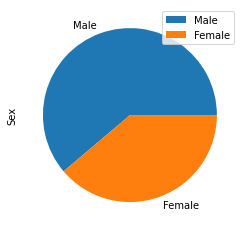

In [22]:
menor50K['Sex'].value_counts().plot(kind='pie')
plt.legend()

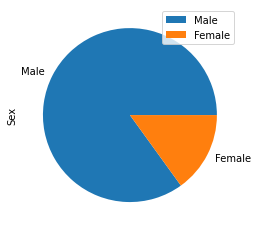

In [23]:
maior50K['Sex'].value_counts().plot(kind='pie')
plt.legend()

Mesmo com proporcionalmente um maior número de homens na população estudada, a desigualdade de gênero é evidente nos dados, pois há uma quantia pequena de mulheres com renda anual maior que 50 mil dólares.

Text(0.5, 0, 'Horas semanais trabalhadas')

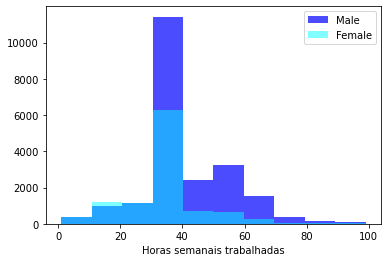

In [24]:
male = adult_train[adult_train['Sex'] == 'Male']
female = adult_train[adult_train['Sex'] == 'Female']

male['Hours per week'].hist(color = 'blue', alpha = 0.7, grid = False, label = 'Male')
female['Hours per week'].hist(color = 'cyan', alpha = 0.5, grid = False, label = 'Female')

plt.legend()
plt.xlabel('Horas semanais trabalhadas')

Text(0.5, 0, 'Horas semanais trabalhadas')

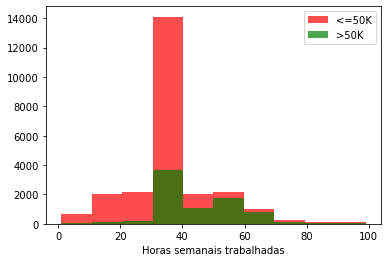

In [25]:
menor50K = adult_train[adult_train['Target'] == '<=50K']
maior50K = adult_train[adult_train['Target'] == '>50K']

menor50K['Hours per week'].hist(color = 'red', alpha = 0.7, grid = False, label = '<=50K')
maior50K['Hours per week'].hist(color = 'green', alpha = 0.7, grid = False, label = '>50K')

plt.legend()
plt.xlabel('Horas semanais trabalhadas')

A partir destes dados, conclui-se que, nessa população, os homens tendem a trabalhar mais horas do que as mulheres, além disso, pessoas com maior renda anual também tendem a trabalhar mais horas por semana. 

* **Capital Gain e Capital Loss:**

Text(0.5, 0, 'Ganho de capital')

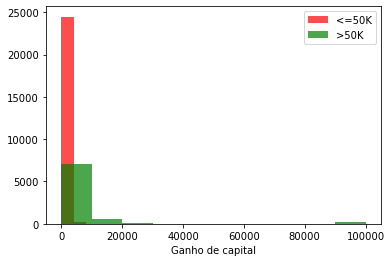

In [26]:
menor50K = adult_train[adult_train['Target'] == '<=50K']
maior50K = adult_train[adult_train['Target'] == '>50K']

menor50K['Capital Gain'].hist(color = 'red', alpha = 0.7, grid = False, label = '<=50K')
maior50K['Capital Gain'].hist(color = 'green', alpha = 0.7, grid = False, label = '>50K')

plt.legend()
plt.xlabel('Ganho de capital')

Text(0.5, 0, 'Perda de capital')

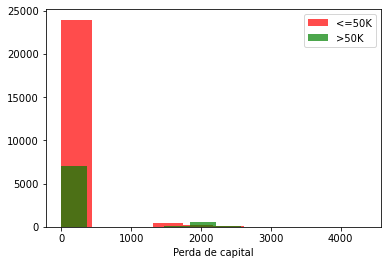

In [27]:
menor50K = adult_train[adult_train['Target'] == '<=50K']
maior50K = adult_train[adult_train['Target'] == '>50K']

menor50K['Capital Loss'].hist(color = 'red', alpha = 0.7, grid = False, label = '<=50K')
maior50K['Capital Loss'].hist(color = 'green', alpha = 0.7, grid = False, label = '>50K')

plt.legend()
plt.xlabel('Perda de capital')

É muito interessante notar o fato de que a maioria, na populção estudada, dos quais ganha menos do que 50 mil dólares anuais não possuem alto ganho ou perda de capital, tais valores mais expressivos relacionam-se com aqueles com renda anual maior.

* **Country:**

In [28]:
adult_train['Country'].value_counts()

United-States                 29169
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

Há uma grande concentração de estadunidenses na população estudada, constituindo 89,6% da totalidade. Por isso, o rótulo Country será desconsiderado.

Após a análise dos dados, conclui-se que os rótulos: Workclass, fnlwgt, Education, Occupation, relationship e Country não são suficientemente relevantes para a classificação e por isso serão desconsiderados. 

# 3. **Classificador K-NN**



Nesta etapa, ira se fazer o tratamento final dos dados e a implantação do classificador K-NN.

* **Tratamento dos Dados:**

Removem-se as colunas com os dados, cujos rótulos decidiu-se desconsiderar.

In [29]:
Adult_train_final = Nadult_train[['Age', 'education-num', 'Martial Status', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week']]
Adult_test_final= adult_test[['Age', 'education-num', 'Martial Status', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week']]
Adult_train_final.head()


,Age,education-num,Martial Status,Race,Sex,Capital Gain,Capital Loss,Hours per week
0,34,10,Divorced,White,Male,0,0,44
1,58,6,Married-civ-spouse,White,Male,0,0,40
2,25,10,Never-married,White,Male,0,0,42
3,24,10,Divorced,White,Female,0,0,40
4,57,9,Married-civ-spouse,White,Male,5178,0,60


Abaixo, convertem-se os dados não numéricos: Martial Status, Race e Sex em numéricos.

In [30]:
numAdult_train_final = Adult_train_final.apply(preprocessing.LabelEncoder().fit_transform)
numAdult_test_final = Adult_test_final.apply(preprocessing.LabelEncoder().fit_transform)

X = numAdult_train_final
Y = Nadult_train['Target']
X_test = numAdult_test_final

* **Definição do K com maior acurácia:**

In [31]:
BestK = 15
BestAcuraccy = 0.0

for k in range(10, 35):
    acuracia = cross_val_score(KNeighborsClassifier(n_neighbors=k), X, Y, cv=10, scoring="accuracy").mean()
    print('k = ', k, ' ;  Acurácia: ', acuracia)
    print('\n')
    if acuracia > BestAcuraccy:
        BestAcuraccy = acuracia
        BestK = k
        
print('O k com maior acurácia é: ', BestK)
print('Melhor acurácia: ', BestAcuraccy)

k =  10  ;  Acurácia:  0.8345878109809226


k =  11  ;  Acurácia:  0.8348199394413092


k =  12  ;  Acurácia:  0.8357151319358295


k =  13  ;  Acurácia:  0.8358145245026195


k =  14  ;  Acurácia:  0.8380028424251961


k =  15  ;  Acurácia:  0.8365108769141092


k =  16  ;  Acurácia:  0.8373396684921606


k =  17  ;  Acurácia:  0.8362456029449389


k =  18  ;  Acurácia:  0.8373064790238164


k =  19  ;  Acurácia:  0.8372402099860297


k =  20  ;  Acurácia:  0.8369416146698331


k =  21  ;  Acurácia:  0.835814480543059


k =  22  ;  Acurácia:  0.8382348060372301


k =  23  ;  Acurácia:  0.8380358560552976


k =  24  ;  Acurácia:  0.837206943588454


k =  25  ;  Acurácia:  0.8382679735257941


k =  26  ;  Acurácia:  0.8374722505272949


k =  27  ;  Acurácia:  0.8373396355224901


k =  28  ;  Acurácia:  0.8380690565135321


k =  29  ;  Acurácia:  0.8366764835692349


k =  30  ;  Acurácia:  0.8381685260095532


k =  31  ;  Acurácia:  0.8376380769802243


k =  32  ;  Acurácia:  0.837339690

* **Predição**

Por fim, o classificador K-NN é construído para prever a coluna 'Target', a partir dos dados de treino e com a utilização de K = 25.

In [32]:
cknn = KNeighborsClassifier(n_neighbors=25)
cknn.fit(X, Y)

KNeighborsClassifier(n_neighbors=25)

In [33]:
prediction = cknn.predict(X_test)
prediction

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '>50K'],
      dtype=object)

Então formatamos os resultados para csv:

In [34]:
submission = pd.DataFrame(prediction, columns=['Income'])
submission.head()

,Income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,>50K


In [35]:
submission.shape

(16280, 1)

In [36]:
submission.to_csv('submission.csv', index_label = 'Id')
